In this article we will go over how to use the `Flash.vision.ImageClassifier` to train your own deep learning model! We'll start off by importing the various libraries we will need to use:

In [1]:
from pathlib import Path
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO
from PIL import Image
from sklearn.model_selection import train_test_split
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt


# Flash and PyTorch Lightning
from pl_flash.vision import ImageClassifier, ImageClassificationData
import pytorch_lightning as pl

Next, we will download some data. Here we will be using a dataset consisting of images of cats and dogs, so we can train a model to differentiate between the two. Feel free to use any other dataset with as many categories as you would like!

In [2]:
data_path = Path("data/dogs-vs-cats/")

if not data_path.exists():
    with urlopen("https://pl-flash-data.s3.amazonaws.com/dogs-vs-cats.zip") as resp:
        with ZipFile(BytesIO(resp.read())) as file:
            file.extractall('data/')

/home/teddy/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


With the files downloaded, we can gather all of the images in a list simply by looking for files with the `.jpg` extension:

In [3]:
files = list(data_path.glob("*.jpg"))
pprint(files[:5])  # print first 5 files

[PosixPath('data/dogs-vs-cats/dog.3781.jpg'),
 PosixPath('data/dogs-vs-cats/dog.10546.jpg'),
 PosixPath('data/dogs-vs-cats/dog.9858.jpg'),
 PosixPath('data/dogs-vs-cats/cat.12197.jpg'),
 PosixPath('data/dogs-vs-cats/cat.10233.jpg')]


We can see that each image includes either `cat` or `dog` in the filename, so we can use this to generate our labels for each image:

In [4]:
labels = ["cat" if "cat" in f.name else "dog" for f in files]
pprint(labels[:5])  # print first 5 labels

['dog', 'dog', 'dog', 'cat', 'cat']


Before we create our dataset, lets just make sure the images and labels look correct:

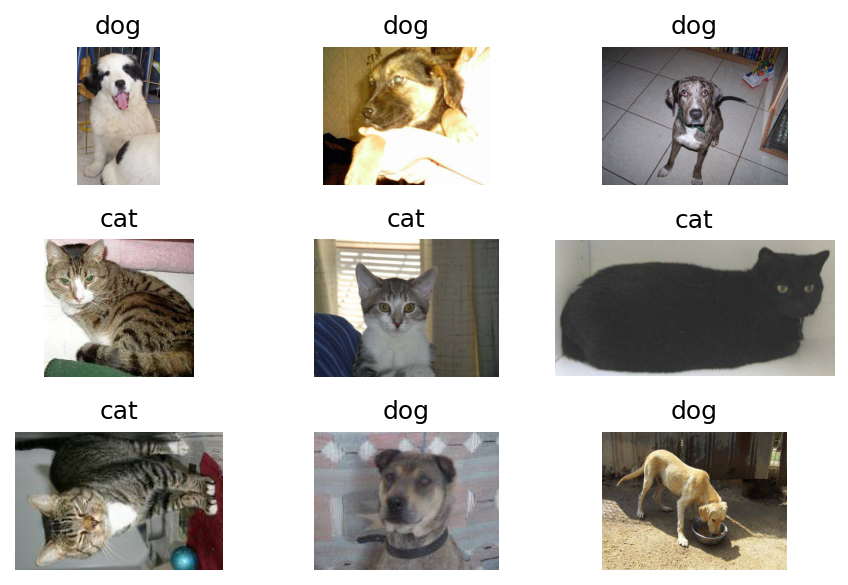

In [5]:
fig = plt.figure(figsize=(6,4), dpi=150)
for i in range(9):
    fig.add_subplot(3, 3, i + 1)
    plt.imshow(Image.open(files[i]))
    plt.title(labels[i]); plt.axis("off")
fig.tight_layout()

In [6]:
train_files, test_files, train_labels, test_labels = train_test_split(
    files, labels, test_size=0.10
)
train_files, valid_files, train_labels, valid_labels = train_test_split(
    train_files, train_labels, test_size=0.10
)

In [11]:
data = ImageClassificationData.from_filepaths(
    train_filepaths=train_files, 
    train_labels=train_labels,
    valid_filepaths=valid_files,
    valid_labels=valid_labels,
    test_filepaths=test_files,
    test_labels=test_labels,
)

In [12]:
task = ImageClassifier(num_classes=2, metrics=pl.metrics.Accuracy())

In [13]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=5,
    log_every_n_steps=1,
)

trainer.fit(task, data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | metrics  | ModuleDict | 0     
1 | backbone | Sequential | 11 M  
2 | head     | Sequential | 1 K   


1

In [10]:
trainer.test();

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': tensor(0.9400, device='cuda:0'),
 'test_cross_entropy': tensor(0.2033, device='cuda:0'),
 'train_accuracy': tensor(1., device='cuda:0'),
 'train_cross_entropy': tensor(0.2229, device='cuda:0'),
 'val_accuracy': tensor(0.9256, device='cuda:0'),
 'val_cross_entropy': tensor(0.2121, device='cuda:0')}
--------------------------------------------------------------------------------

